In [38]:
import numpy as np
import pandas as pd
from logistic_regression import LogRegCCD
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score, precision_recall_curve, auc
import warnings
warnings.filterwarnings('ignore')


In [8]:
# Performance of algorithms regarding different metrics (ROC AUC, Recall-Precision AUC, F- measure and Balanced Accuracy) on real datasets

df_1 = pd.read_csv(r'datasets/parkinson/df_parkinson.csv')
df_2 = pd.read_csv(r'datasets/swarm/df_swarm.csv')
df_3 = pd.read_csv(r'datasets/wine/df_wine.csv')
dfs = [df_1, df_2, df_3]

In [39]:
def create_results_df(dfs, random_state=12, repeats=10):
    
    rows = []

    np.random.seed(random_state)

    iterations = 10
    alpha = 0.9
    lmbda = 0.9

    for df in dfs:
        X, y = df.iloc[:,:-1].values, df.iloc[:,-1:].values.ravel()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)

        lr = LogRegCCD()
        X_train_std = lr._initialize(X_train)
        X_test_std = lr._initialize(X_test)
        
        test_acc_ccd = [None] * repeats
        test_roc_ccd = [None] * repeats
        test_f1_cdd = [None] * repeats
        test_rp_cdd = [None] * repeats

        test_acc_sklearn = [None] * repeats
        test_roc_sklearn = [None] * repeats
        test_f1_sklearn = [None] * repeats
        test_rp_sklearn = [None] * repeats

        for i in range(repeats):
            lr = LogRegCCD()
            lr.fit(iterations, X_train, y_train, alpha, lmbda)
            y_prob_cdd = lr.predict_proba(X_test)


            test_acc_ccd[i] = lr.validate(X_test, y_test, 'balanced_accuracy')
            test_roc_ccd[i] = lr.validate(X_test, y_test, 'roc_auc')
            test_f1_cdd[i] = lr.validate(X_test, y_test, 'f1')

            precision_cdd, recall_cdd, _ = precision_recall_curve(y_test, y_prob_cdd)
            test_rp_cdd[i] = auc(recall_cdd, precision_cdd)
    
            lr_sklearn = LogisticRegression(penalty=None, max_iter=iterations, fit_intercept=False)
            lr_sklearn.fit(X_train_std, y_train)
            y_pred_sklearn = lr_sklearn.predict(X_test_std)
            y_prob_sklearn = lr_sklearn.predict_proba(X_test_std)[:, 1]
            
            test_acc_sklearn[i] = balanced_accuracy_score(y_test, y_pred_sklearn)
            test_roc_sklearn[i] = roc_auc_score(y_test, y_prob_sklearn)
            test_f1_sklearn[i] = f1_score(y_test, y_pred_sklearn)

            precision_sklearn, recall_sklearn, _ = precision_recall_curve(y_test, y_prob_sklearn)
            test_rp_sklearn[i] = auc(recall_sklearn, precision_sklearn)
            

        rows.append(['parkinson' if df.equals(df_1) else 'swarm' if df.equals(df_2) else 'wine',
                      np.mean(test_acc_ccd), np.mean(test_acc_sklearn),
                      np.mean(test_roc_ccd), np.mean(test_roc_sklearn),
                      np.mean(test_f1_cdd), np.mean(test_f1_sklearn),
                      np.mean(test_rp_cdd), np.mean(test_rp_sklearn)])

    df = pd.DataFrame(rows, columns=['dataset',
                                     'test_acc_ccd', 'test_acc_sklearn',
                                     'test_roc_ccd', 'test_roc_sklearn',
                                     'test_f1_cdd', 'test_f1_sklearn',
                                     'test_rp_cdd', 'test_rp_sklearn'])

    return df

In [40]:
df = create_results_df(dfs, random_state=12, repeats=1)

In [41]:
for column in df.columns[1:]:
    df[column] = df[column].apply(lambda x: round(x, 3))

In [42]:
df.to_csv('CDD_vs_Sklearn_measures_df.csv', index=False)
df

,dataset,test_acc_ccd,test_acc_sklearn,test_roc_ccd,test_roc_sklearn,test_f1_cdd,test_f1_sklearn,test_rp_cdd,test_rp_sklearn
0,parkinson,0.792,0.799,0.900,0.877,0.900,0.900,0.959,0.952
1,swarm,0.999,1.000,1.000,1.000,0.998,1.000,1.000,1.000
2,wine,0.484,0.485,0.475,0.480,0.553,0.558,0.548,0.559


In [ ]:
from pandasql import sqldf

def df_to_latex(df, table_name="Table name"):
    latex_str = """
    \\begin{table}[H]
        \centering
        \\begin{tabular}{|m{1.5cm}|m{2.55cm}|m{3.15cm}|m{2.55cm}|m{3.15cm}|}
        \hline
    """
    
    # Column headers
    latex_str += "        " + " & ".join(["\\textbf{{{}}}".format(col.replace('_', '\\_' )) for col in df.columns]) + "\\\\ \hline\n"
    
    # Data rows
    for _, row in df.iterrows():
        latex_str += "        " + " & ".join(map(str, row)) + "\\\\ \hline\n"
    
    latex_str += f"""
        \end{{tabular}}
        \caption{{{table_name}}}
    \end{{table}}
    """
    
    return latex_str

print(df_to_latex(df.loc[:, ['dataset', 'test_acc_ccd', 'test_acc_sklearn', 'test_roc_ccd', 'test_roc_sklearn']], 'Measures of LogRegCDD vs LogisticRegression - set 1 '))
print(df_to_latex(df.loc[:, ['dataset', 'test_f1_cdd', 'test_f1_sklearn', 'test_rp_cdd', 'test_rp_sklearn']], 'Measures of LogRegCDD vs LogisticRegression - set 2'))


    \begin{table}[H]
        \centering
        \begin{tabular}{|m{1.5cm}|m{3cm}|m{3cm}|m{3cm}|m{3cm}|}
        \hline
            \textbf{dataset} & \textbf{test\_acc\_ccd} & \textbf{test\_acc\_sklearn} & \textbf{test\_roc\_ccd} & \textbf{test\_roc\_sklearn}\\ \hline
        parkinson & 0.792 & 0.799 & 0.9 & 0.877\\ \hline
        swarm & 0.999 & 1.0 & 1.0 & 1.0\\ \hline
        wine & 0.484 & 0.485 & 0.475 & 0.48\\ \hline

        \end{tabular}
        \caption{Measures of LogRegCDD vs LogisticRegression - set 1 }
    \end{table}
    

    \begin{table}[H]
        \centering
        \begin{tabular}{|m{1.5cm}|m{3cm}|m{3cm}|m{3cm}|m{3cm}|}
        \hline
            \textbf{dataset} & \textbf{test\_f1\_cdd} & \textbf{test\_f1\_sklearn} & \textbf{test\_rp\_cdd} & \textbf{test\_rp\_sklearn}\\ \hline
        parkinson & 0.9 & 0.9 & 0.959 & 0.952\\ \hline
        swarm & 0.998 & 1.0 & 1.0 & 1.0\\ \hline
        wine & 0.553 & 0.558 & 0.548 & 0.559\\ \hline

        \end{tabular}
        \

In [51]:
# Values of coefficients obtained in these two methods

import seaborn as sns
import matplotlib.pyplot as plt

def create_coeffs(dfs, random_state=12):
    np.random.seed(random_state)

    iterations = 10
    alpha = 0.9
    lmbda = 0.9

    coeffs_ccd = []
    coeffs_sklearn = []

    for df in dfs:
        dataset_name = 'parkinson' if df.equals(df_1) else 'swarm' if df.equals(df_2) else 'wine'

        X, y = df.iloc[:, :-1].values, df.iloc[:, -1:].values.ravel()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)

        lr = LogRegCCD()
        lr.fit(iterations, X_train, y_train, alpha, lmbda)
        coeffs_ccd.append((dataset_name, lr.beta))

        X_train_std = lr._initialize(X_train)

        

        lr_sklearn = LogisticRegression(penalty=None, max_iter=iterations, fit_intercept=False)
        lr_sklearn.fit(X_train_std, y_train)

        coeffs_sklearn.append((dataset_name, lr_sklearn.coef_.flatten()))

    plot_coefficients(coeffs_ccd, coeffs_sklearn)

def plot_coefficients(coeffs_ccd, coeffs_sklearn):
    fig, axes = plt.subplots(len(set([x[0] for x in coeffs_ccd])), 2, figsize=(12, 8))
    datasets = list(set([x[0] for x in coeffs_ccd]))

    for i, dataset in enumerate(datasets):
        ccd_values = [x[1] for x in coeffs_ccd if x[0] == dataset]
        sklearn_values = [x[1] for x in coeffs_sklearn if x[0] == dataset]

        sns.histplot(np.hstack(ccd_values), bins=20, kde=True, ax=axes[i, 0])
        axes[i, 0].set_title(f"{dataset} - LogRegCCD Coefficients")
        
        sns.histplot(np.hstack(sklearn_values), bins=20, kde=True, ax=axes[i, 1])
        axes[i, 1].set_title(f"{dataset} - Sklearn LogisticRegression Coefficients")

    plt.tight_layout()
    plt.savefig('LogRegCCD_vs_LogisticRegression_coeffs_comparison.png')
    plt.show()


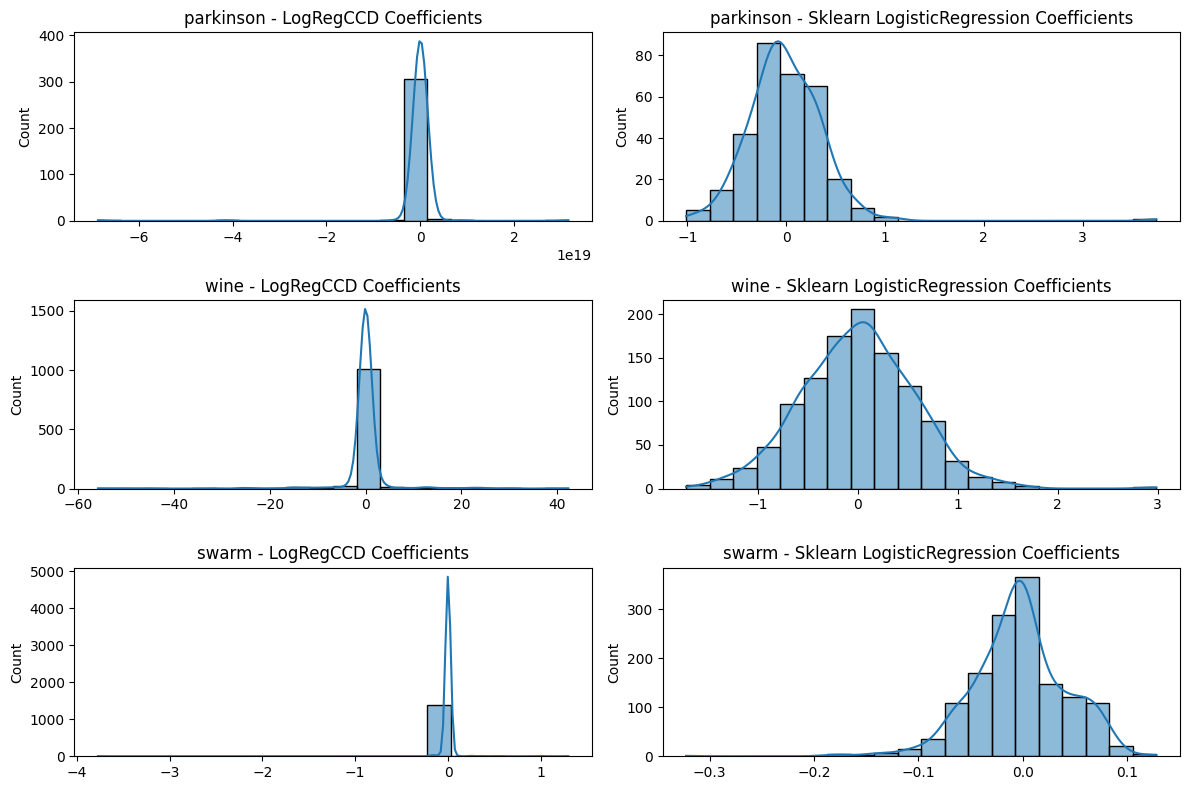

In [52]:
create_coeffs(dfs)